In [1]:
!nvidia-smi

Tue May 21 17:09:39 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.44                 Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   43C    P8             11W /  120W |     356MiB /   6144MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 🧪 PIP INSTALL
Instalar pacotes: Autodistill, GroundedDINO, YOLOv8, Supervision e Roboflow


In [2]:
%pip install -q \
autodistill \
autodistill-grounding-dino \
autodistill-yolov8 \
supervision==0.9.0 \
roboflow 

Note: you may need to restart the kernel to use updated packages.


# 🗂️ IMPORT
**NOTE**: Bibliotecas principais como autodistill (CaptionOntology, GroundedSAM e YOLOv8) para lidar com rotulagem automatica e detecção de objetos


In [3]:
import os
import cv2
import random
import shutil
import supervision as sv
from autodistill.detection import CaptionOntology
from autodistill_grounding_dino import GroundingDINO
from IPython.display import Image

# 🖼️ PREPARANDO DADOS

### Escolher aleatoriamente as imagens

In [4]:
def copiar_imagens_aleatorias(pasta_imagens, pasta_destino, qte):
    imagens_disponiveis = os.listdir(pasta_imagens)

    if len(imagens_disponiveis) < qte:
        print("A pasta não contém imagens suficientes")
        return

    imagens_selecionadas = random.sample(imagens_disponiveis, qte)

    for imagem in imagens_selecionadas:
        caminho_imagem_origem = os.path.join(pasta_imagens, imagem)
        caminho_imagem_destino = os.path.join(pasta_destino, imagem)
        shutil.copy(caminho_imagem_origem, caminho_imagem_destino)

    print(f"{qte} imagens selecionadas e copiadas com sucesso")


pasta_imagens = "C:/Users/vitor/.vscode/scritps/autodistill_yolo/total_images"  # diretorio com todas as imagens do dataset
pasta_destino = "C:/Users/vitor/.vscode/scritps/autodistill_yolo/images"        # diretorio com as imagens selecionadas aleatoriamente
quantidade_imagens = 10

copiar_imagens_aleatorias(pasta_imagens, pasta_destino, quantidade_imagens)

10 imagens selecionadas e copiadas com sucesso


Diretório chamado `images` no dict `HOME`, para carregar as imagens e vizualizando

In [5]:
HOME = os.getcwd()
print(HOME)

C:\Users\vitor\.vscode\scritps\autodistill_yolo


### Exibir amostra de imagem não rotulada

In [6]:
IMAGE_DIR_PATH = f"{HOME}/images"    # diretorio de imagens 
DATASET_DIR_PATH = f"{HOME}/dataset" # diretorio de treinamento do dataset

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png"])

print(f"Quantidades de imagens: {len(image_paths)}")

Quantidades de imagens: 10


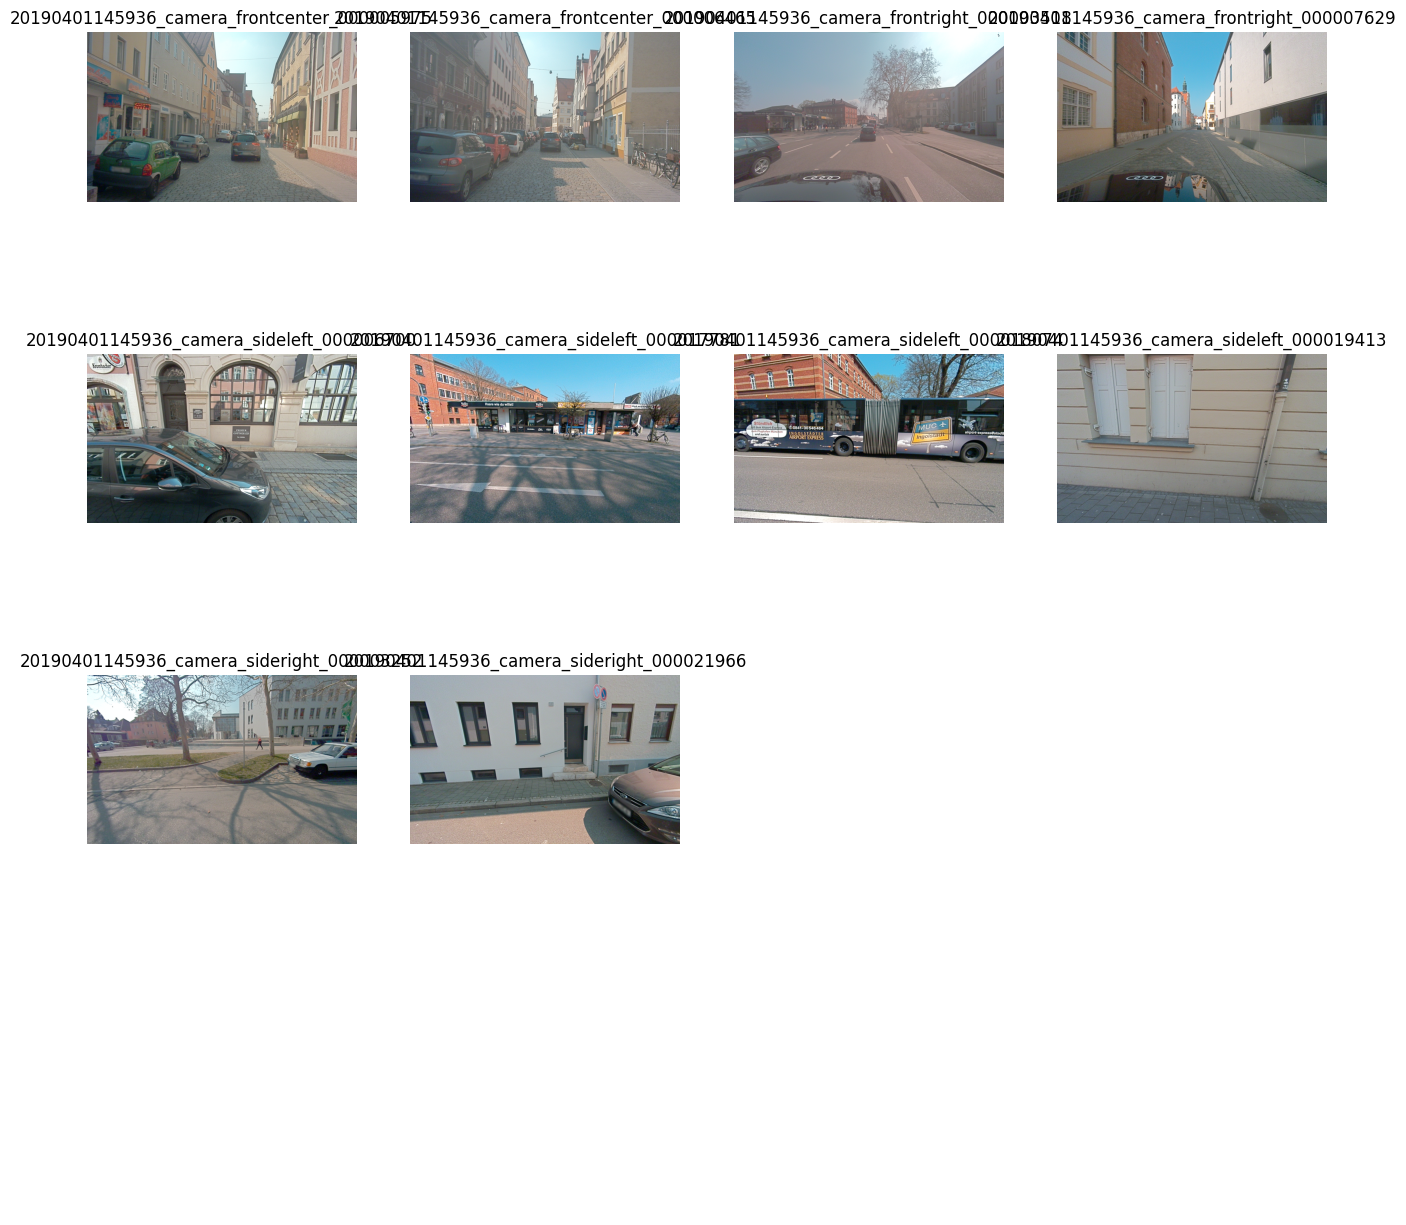

In [7]:
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

# 🪄 AUTODISTILL: ROTULO AUTOMATICO

### Definir ontologia

**Ontologia** - uma Ontologia define como seu Modelo Base é solicitado, o que seu Conjunto de Dados descreverá e o que seu Modelo Alvo irá prever. Uma ontologia simples é a CaptionOntology que solicita um modelo base com legendas de texto e as mapeia para nomes de classes.

In [8]:
"""
  Ontology: como o modelo base é solicitado
  Descreve o que voce realmente ve no conjunto de dados e no que deseja treinar
  seu modelo destino

  Lancar os prompts e classes para gerar as mascaras de segmentacao
    -> (prompt : class)
"""

ontology=CaptionOntology({
  "Car" : "Car",
  "Motorcycle" : "Motorcycle",
  "Pedestrian" : "Pedestrian"
})

### Iniciar modelo base e rótulo automático

**Ontologia** - define como seu Modelo Base é solicitado, o que seu Conjunto de Dados descreverá e o que seu Modelo Alvo irá prever. Uma ontologia simples é aquela CaptionOntologyque solicita um modelo base com legendas de texto e os mapeia para nomes de classes.
- Uma ontologia em Computação é um modelo de dados que representa um conjunto de conceitos dentro de um domínio e os relacionamentos entre estes.

In [9]:
# Modelo base é iniciado por ontology
base_model = GroundingDINO(ontology=ontology)   # modelo base: GroundingDINO
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,                # entrada de dados
    extension=".png",                           # extensao da imagem .png
    output_folder=DATASET_DIR_PATH)             # armazena a saida dos dados rotulados

trying to load grounding dino directly


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)


final text_encoder_type: bert-base-uncased


expandable_segments not supported on this platform (Triggered internally at ..\c10/cuda/CUDAAllocatorConfig.h:30.)
Labeling C:\Users\vitor\.vscode\scritps\autodistill_yolo/images\20190401145936_camera_frontcenter_000005975.png:   0%|          | 0/10 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
Labeling C:\Users\vitor\.vscode\scritps\autodistill_yolo/images\20190401145936_camera_sideright_000021966.png: 100%|██████████| 10/10 [00:20<00:00,  2.09s/it] 


Labeled dataset created - ready for distillation.


### Exibir amostra do conjunto de dados

**Conjunto de dados/dataset** - dados rotulados automaticamente que pode ser usado para treinar um modelo de destino, como por exemplo YOLOv8. É a saída gerada por um Modelo Base.

In [10]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels" # dados de rotulagem das imagens treinadas
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"      # imagens de treino rotuladas
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"                # arquivo formato YOLO.yaml

**NOTA**: a quantidade de imagens total é dividida em `train` e `valid`

In [11]:
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

print(f"Quantidade de imagens de treinamento: {len(dataset)}") 

Quantidade de imagens de treinamento: 8


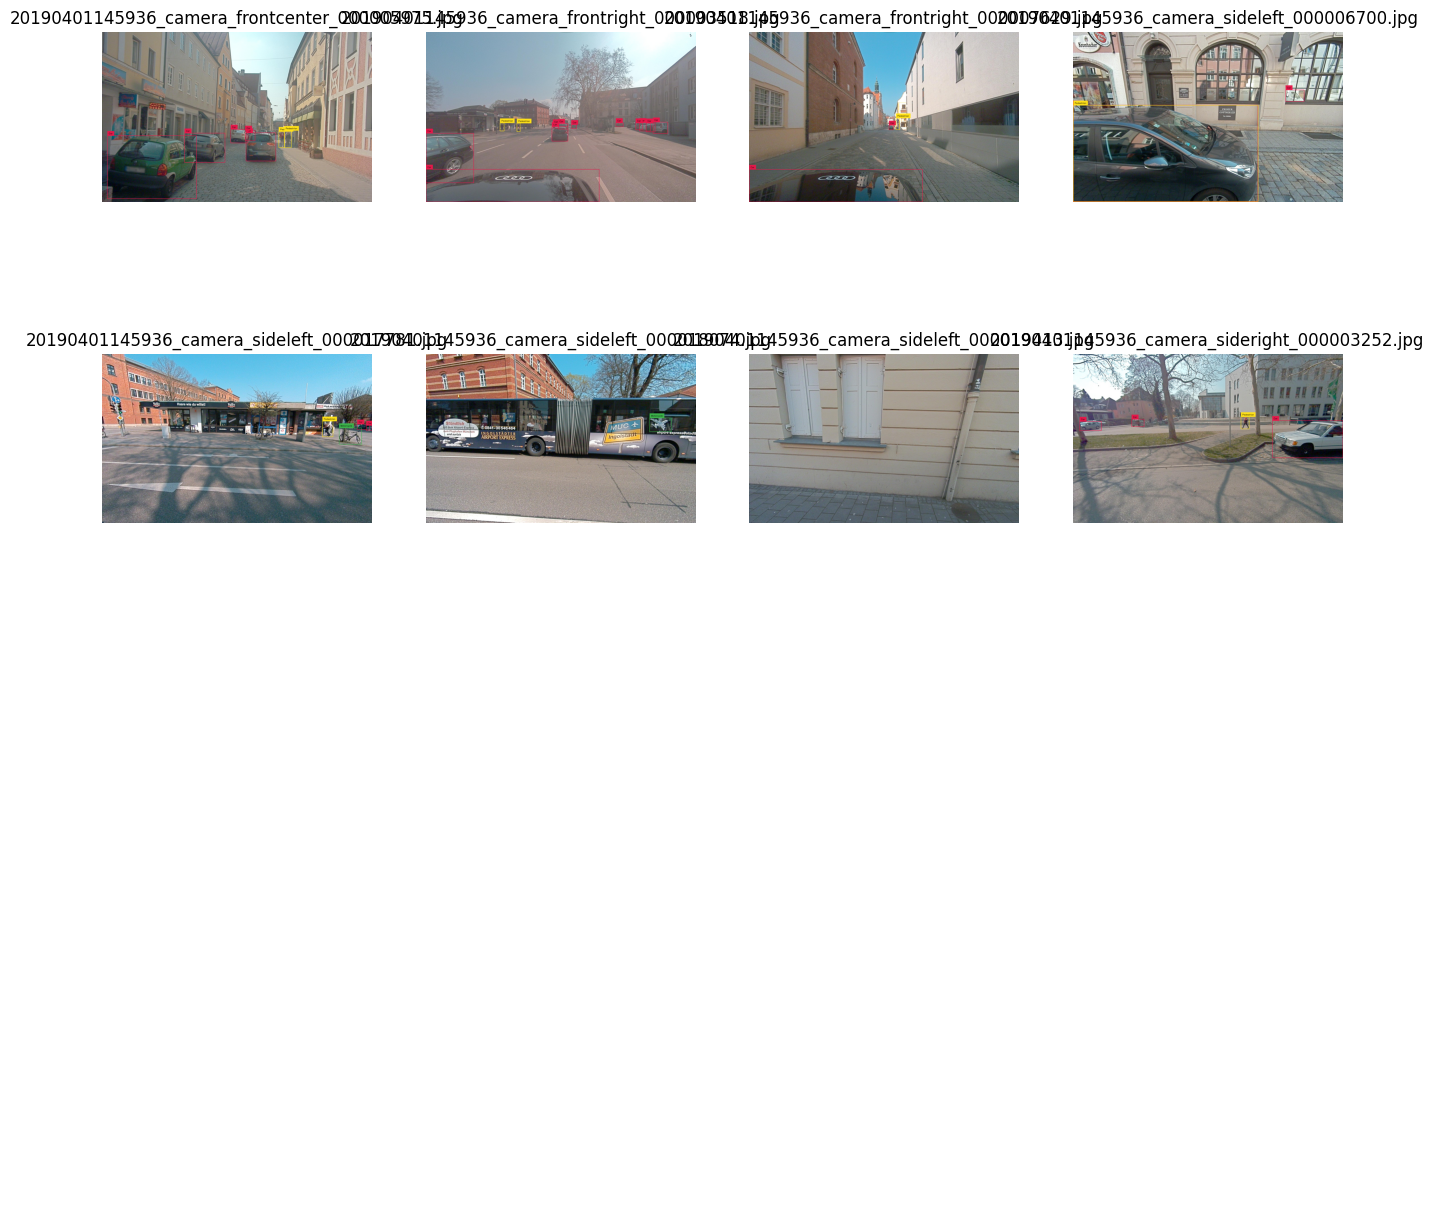

In [12]:
"""
    Exemplos de imagens; Loop for em execucao com todos os parametros que criamessa imagens com as caixas delimitadoras; 
    e tambem dados demograficos para tracar nossa grade de imagens.
"""

SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

# 🚘YOLOV8


### Treinamento do modelo
**Modelo de destino** – é um modelo supervisionado que consome um conjunto de dados e gera um modelo destilado que está pronto para implantação. Os modelos de destino geralmente são pequenos, rápidos e ajustados para executar muito bem uma tarefa específica (mas não generalizam muito além das informações descritas em seu conjunto de dados).

**NOTA**: A interface de linha de comando YOLO (CLI) permite comandos simples de linha única sem a necessidade de um ambiente Python. CLI não requer personalização ou código Python . Podes simplesmente executar todas as tarefas a partir do terminal com o comando yolo comanda.

Ultralytics yolo utiliza a seguinte sintaxe:
```python
  yolo TASK MODE ARGS

  Where   TASK (optional) is one of [detect, segment, classify]
          MODE (required) is one of [train, val, predict, export, track]
          ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
```

In [ ]:
!yolo task=detect mode=train model=yolov8n.pt data={DATASET_DIR_PATH}/data.yaml epochs=5 imgsz=640 batch=2 name="<testx/model_epochs_imagens_mode>"

### Validando o modelo de treinamento
Fornece um conjunto robusto de ferramentas e métricas para avaliar o desempenho dos teus modelos de deteção de objectos
- Precisão e Ajuste de hiperparâmetros

**NOTA**: Os arquivos de treinamento foram gerados e armazenados no diretorio `runs`.

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/<testx/model_epochs_imagens_mode>/weights/best.pt data={DATASET_DIR_PATH}/data.yaml name="<testx/model_epochs_imagens_mode>"

### Exibir resultados de treinamento e validacao
**NOTA**: Os arquivos dos resultados de treinamento e validacao foram gerados e armazenados no diretorio `runs\detect\testx`, onde x é numero de 1 a n.

**Matriz de confusao**

In [ ]:
Image(filename=f'{HOME}/runs/detect/<testx/model_epochs_imagens_mode>/confusion_matrix.png', width=600)

**Metricas de treinamento**

In [ ]:
Image(filename=f'{HOME}/runs/detect/<testx/model_epochs_imagens_mode>/results.png', width=600)

**Imagens validadas**

In [ ]:
Image(filename=f'{HOME}/runs/detect/<testx/model_epochs_imagens_mode>/val_batch0_labels.jpg', width=600)

In [ ]:
"""   
### Executar inferência em um vídeo
Utiliza um modelo YOLOv8x treinado para executar previsões em imagens

# Determinar caminhos de input e output de video
# = TEST_VIDEO_PATHS[0]                                                          # primeiro vídeo da lista                       
OUTPUT_VIDEO_PATH = f"{HOME}/output.mp4"                                                        # nome do vídeo de saída    
TRAINED_MODEL_PATH = f"{HOME}/runs/detect/<testx/model_epochs_imagens_mode>/weights/best.pt"    # melhor modelo treinado

%cd {HOME}

!yolo \
predict \
model={TRAINED_MODEL_PATH} \
source={INPUT_VIDEO_PATH}

"""